In [43]:
%matplotlib inline
!pip install yacs timm einops opencv-python

In [62]:
# Part 1 (Setup)
from google.colab import drive #Because the Swin Base is so large, we need to first put it into our Google Drives
drive.mount('/content/drive')

!pip install -q yacs timm einops opencv-python Pillow ipywidgets transformers scikit-learn

# Clone repo if not yet
!git clone https://github.com/jlianglab/Ark.git || echo "Repo already exists"
%cd /content/Ark

# Part 2 (Load SimMIM model/Swin backbone)
import sys, os, torch, numpy as np
sys.path.append('/content/Ark/Ark_Plus/Finetuning/simmim')
from config import get_config
from models.build import build_model

class Args:
    def __init__(self):
        self.cfg = "/content/Ark/Ark_Plus/Finetuning/simmim/configs/simmim_finetune__swin_base__img224_window7__800ep.yaml"
        self.opts = None

args = Args()
config = get_config(args)
print("✅ Config loaded")

model = build_model(config, is_pretrain=False)
model.eval()
print("✅ Ark⁺ visual encoder (Swin backbone) built")


# Part 3 (Checkpoint)

torch.serialization.add_safe_globals([np.core.multiarray.scalar])
ckpt_path = "/content/drive/MyDrive/Ark6_swinLarge768_ep50.pth.tar"  #May need to adjust

ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=False)
if 'state_dict' in ckpt:
    model.load_state_dict(ckpt['state_dict'], strict=False)
else:
    model.load_state_dict(ckpt, strict=False)

print("✅ Ark⁺ Nature weights loaded successfully!")

# Part 4 (Feature Extraction)
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

@torch.no_grad()
def encode_image(img_path):
    """Extract Ark⁺ visual embedding without needing mask."""
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0)

    feat = None
    if hasattr(model, "backbone") and hasattr(model.backbone, "forward_features"):
        feat = model.backbone.forward_features(x)
    elif hasattr(model, "encoder") and hasattr(model.encoder, "forward_features"):
        feat = model.encoder.forward_features(x)
    elif hasattr(model, "forward_features"):
        feat = model.forward_features(x)
    else:
        # fallback: zero mask if model(x, mask)
        patch = 4
        L = (224 // patch) * (224 // patch)
        mask = torch.zeros((1, L), dtype=torch.bool)
        feat = model(x, mask)

    if feat.ndim == 4:
        feat = feat.mean(dim=[2,3])
    return F.normalize(feat.flatten(), dim=0)


# Text Endocder Called CLIP (Open-AI's Neural Network)

from transformers import CLIPTokenizer, CLIPTextModel
_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
_text_model.eval()

@torch.no_grad()
def encode_texts(texts):
    tokens = _tokenizer(texts, padding=True, return_tensors="pt")
    text_feats = _text_model(**tokens).pooler_output
    return F.normalize(text_feats, dim=1)


# Zero-Shot Comparison Function

@torch.no_grad()
def zero_shot_inference(image_path, prompts):
    img_feat = encode_image(image_path)       # (D_img,)
    text_feats = encode_texts(prompts)        # (K, D_text)

    # match dimensions (Ark⁺=1024, CLIP=512)
    #Because Ark+ has a different dimension comapred to CLIP, have to truncate the photos
    D = min(text_feats.shape[1], img_feat.shape[0])
    text_feats = text_feats[:, :D]
    img_feat = img_feat[:D]

    sims = torch.matmul(text_feats, img_feat.unsqueeze(1)).squeeze(1)
    return sims

# Part 5 (Changing the Photos)

from ipywidgets import Dropdown, Button, Output, VBox, HBox, Text
from IPython.display import display
import matplotlib.pyplot as plt

img_dir = "/content/drive/MyDrive/X_Rays"
images = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])

dropdown = Dropdown(options=images, description="Select X-ray:", layout={'width':'400px'})
prompt1 = Text(value="pneumonia present", description="Prompt 1:", layout={'width':'400px'})
prompt2 = Text(value="normal chest X-ray", description="Prompt 2:", layout={'width':'400px'})
run_btn = Button(description="Run Zero-Shot", button_style='success')
out = Output()

def run_inference(b):
    out.clear_output()
    with out:
        img_path = os.path.join(img_dir, dropdown.value)
        display(Image.open(img_path).convert("RGB"))
        texts = [prompt1.value.strip(), prompt2.value.strip()]
        sims = zero_shot_inference(img_path, texts)

        print(f"🧠 Ark⁺ Zero-Shot inference on: {dropdown.value}")
        print("\n🔍 Prompts:", texts)
        print("📊 Cosine similarities:", [float(s) for s in sims])

        pred_idx = int(torch.argmax(sims))
        pred_text = texts[pred_idx]
        conf = float(sims[pred_idx])
        print(f"\n✅ Prediction: '{pred_text}' (confidence ≈ {conf:.3f})")

        # bar chart
        plt.figure(figsize=(5,2.5))
        colors = ['tab:green' if i==pred_idx else 'tab:gray' for i in range(len(texts))]
        plt.barh([f"“{t}”" for t in texts], [float(s) for s in sims], color=colors)
        plt.xlabel("Cosine similarity (image ↔ text)")
        plt.title("Ark⁺ Zero-Shot Text–Image Alignment")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

run_btn.on_click(run_inference)
display(VBox([dropdown, HBox([prompt1, prompt2]), run_btn, out]))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'Ark' already exists and is not an empty directory.
Repo already exists
/content/Ark
=> merge config from /content/Ark/Ark_Plus/Finetuning/simmim/configs/simmim_finetune__swin_base__img224_window7__800ep.yaml
✅ Config loaded
✅ Ark⁺ visual encoder (Swin backbone) built
✅ Ark⁺ Nature weights loaded successfully!


✅ Encoded X_Ray_001.png (Pneumonia)
✅ Encoded X_Ray_002.png (Pneumonia)
✅ Encoded X_Ray_003.png (Pneumonia)
✅ Encoded X_Ray_004.png (Pneumonia)
✅ Encoded X_Ray_005.png (Pneumonia)
✅ Encoded X_Ray_006.png (Normal)
✅ Encoded X_Ray_007.png (Normal)
✅ Encoded X_Ray_008.png (Normal)
✅ Encoded X_Ray_009.png (Normal)
✅ Encoded X_Ray_010.png (Normal)


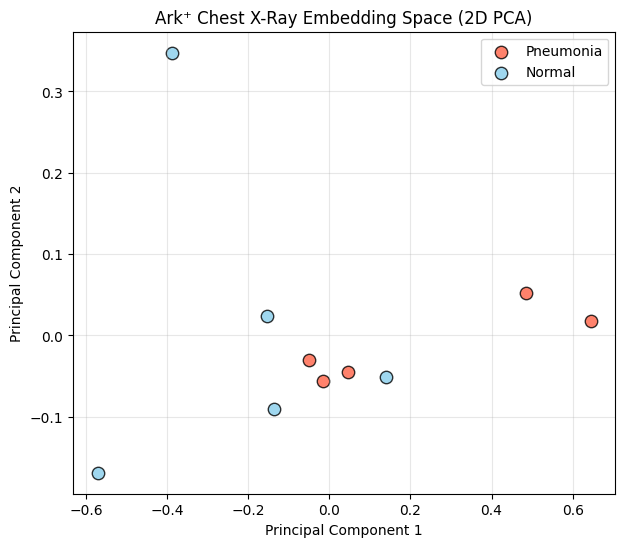

In [63]:
# Part 1 (Imports)

import os, torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Making sure model, encode_image(), encode_texts() already exist from previous cells.

img_dir = "/content/drive/MyDrive/X_Rays"

# Part 2 (Labels)
# Update this manually if needed — simple split rule
# For example, first 5 are pneumonia, last 5 are normal
labels_map = {}
for i in range(1, 11):
    name = f"X_Ray_{i:03d}.png"
    labels_map[name] = "Pneumonia" if i <= 5 else "Normal"

#Part 3 (Encode Images)

features, labels, names = [], [], []

for fname in sorted(os.listdir(img_dir)):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    path = os.path.join(img_dir, fname)
    if fname not in labels_map:
        continue  # skip if not labeled
    try:
        feat = encode_image(path)
        features.append(feat.cpu().numpy())
        labels.append(labels_map[fname])
        names.append(fname)
        print(f"✅ Encoded {fname} ({labels_map[fname]})")
    except Exception as e:
        print(f"⚠️ Error on {fname}: {e}")

features = np.vstack(features)

# Part 4 (Dimesnsion Reduction)

pca = PCA(n_components=2)
reduced = pca.fit_transform(features)
df = pd.DataFrame(reduced, columns=["PC1", "PC2"])
df["Label"] = labels
df["Name"] = names

# Part 5 (Visuals)

plt.figure(figsize=(7,6))
for label, color in zip(["Pneumonia", "Normal"], ["tomato", "skyblue"]):
    subset = df[df["Label"] == label]
    plt.scatter(subset["PC1"], subset["PC2"], c=color, label=label, s=80, alpha=0.8, edgecolors="k")

plt.title("Ark⁺ Chest X-Ray Embedding Space (2D PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()